##Importación de los datos y las librerías necesarias

En primer lugar, importamos drive para tener acceso a los archivos de nuestra carpeta compartida

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importamos las librerías necesarias

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [449]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import plot_tree

Y cargamos nuestros datos en DataFrames

In [276]:
f_total = pd.read_csv('./drive/MyDrive/Proyecto3_CienciaDatos/facultadTotal.csv', delimiter=';')
f_matriculados = pd.read_csv('./drive/MyDrive/Proyecto3_CienciaDatos/facultadMatriculados.csv', delimiter=';')
f_graduados = pd.read_csv('./drive/MyDrive/Proyecto3_CienciaDatos/facultadGraduados.csv', delimiter=';')

In [366]:
p_total = pd.read_csv('./drive/MyDrive/Proyecto3_CienciaDatos/pregradoTotal.csv', delimiter=';')
p_matriculados = pd.read_csv('./drive/MyDrive/Proyecto3_CienciaDatos/pregradoMatriculados.csv', delimiter=';')
p_graduados = pd.read_csv('./drive/MyDrive/Proyecto3_CienciaDatos/pregradoGraduados.csv', delimiter=';')
p_cursos = pd.read_csv('./drive/MyDrive/Proyecto3_CienciaDatos/pregradoCursos.csv', delimiter=';')

## Preparación y visualización de los datos

En primer lugar, trabajamos con los datos segregados por facultad. Utilizaremos el número de estudiantes activos en un periodo específico, la cantidad de estudiantes que se graduaron en ese periodo y los nuevos matriculados.

In [277]:
years = ['2017-1', '2017-2', '2018-1', '2018-2', '2019-1', '2019-2', '2020-1', '2020-2', '2021-1']
facultad = f_total['Facultad']
f_desertores = pd.DataFrame(facultad)

Creamos un nuevo DataFrame donde utilizaremos nuestra ecuación para hallar la cantidad oculta de estudiantes que corresponde a la resta entre deserciones y reingresos 

In [278]:
for i in range(len(years)-1):
  f_desertores[years[i+1]] = f_total[years[i]] + f_matriculados[years[i+1]] - f_graduados[years[i+1]] - f_total[years[i+1]] 

Normalizamos ahora esta cantidad dividiéndola entre los estudiantes totales activos en ese periodo, hallando así la tasa de Deserciones-Reingresos en cada uno de los periodos.

In [279]:
f_desertores = f_desertores[years[1:]]*100/f_total[years[1:]]
f_desertores['Facultad'] = facultad
f_desertores = f_desertores.melt(id_vars = 'Facultad', var_name='Periodo', value_name='Porcentaje').dropna()
f_desertores.head()

,Facultad,Periodo,Porcentaje
0,Administracion,2017-2,-3.445065
1,Arquitectura y Diseno,2017-2,0.203390
2,Artes y Humanidades,2017-2,0.260078
3,Ciencias,2017-2,-0.954198
4,Ciencias Sociales,2017-2,1.112565


Graficamos los datos en forma de diagrama de barras para visualizar las diferencias en cada facultad al pasar los años.

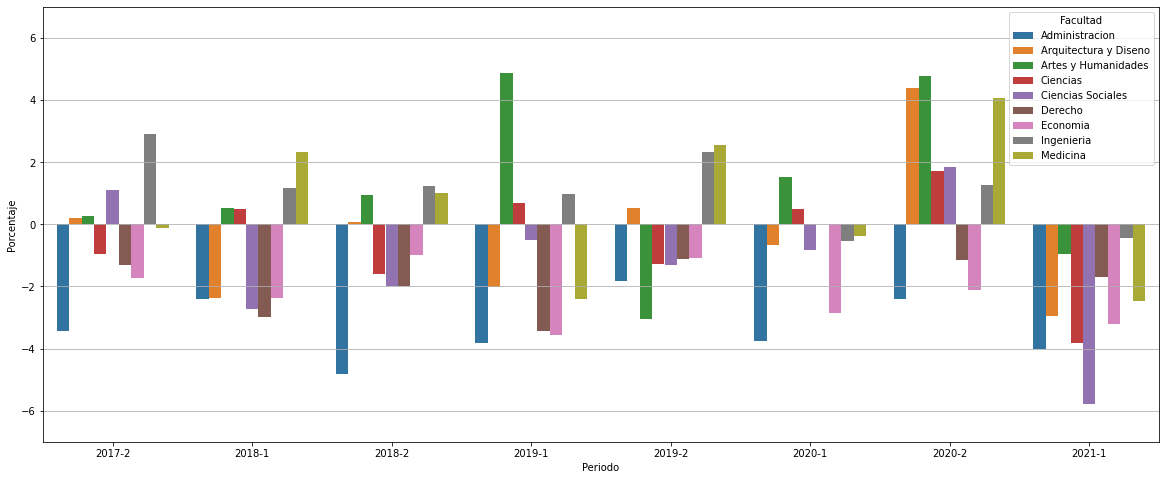

In [280]:
plt.figure(figsize=(20,8))
plt.grid()
plt.ylim(-7,7)
sns.barplot(data=f_desertores, x='Periodo', y='Porcentaje', hue='Facultad')

Realizamos ahora el mismo proceso, pero ahora para los datos obtenidos específicamente de la Facultad de Ciencias.

In [367]:
years = ['2017-1', '2017-2', '2018-1', '2018-2', '2019-1', '2019-2', '2020-1', '2020-2', '2021-1']
programa = p_total['Programa']
p_desertores = pd.DataFrame(programa)

In [368]:
for i in range(len(years)-1):
  p_desertores[years[i+1]] = p_total[years[i]] + p_matriculados[years[i+1]] - p_graduados[years[i+1]] - p_total[years[i+1]] 

In [369]:
p_desertores = p_desertores[years[1:]]*100/p_total[years[1:]]
p_desertores['Programa'] = programa
p_desertoresPlot = p_desertores.melt(id_vars = 'Programa', var_name='Periodo', value_name='Porcentaje').dropna()
p_desertoresPlot.head()

,Programa,Periodo,Porcentaje
0,Biologia,2017-2,2.008032
1,Fisica,2017-2,0.000000
2,Geociencias,2017-2,0.000000
3,Matematicas,2017-2,-7.692308
4,Microbiologia,2017-2,-5.813953


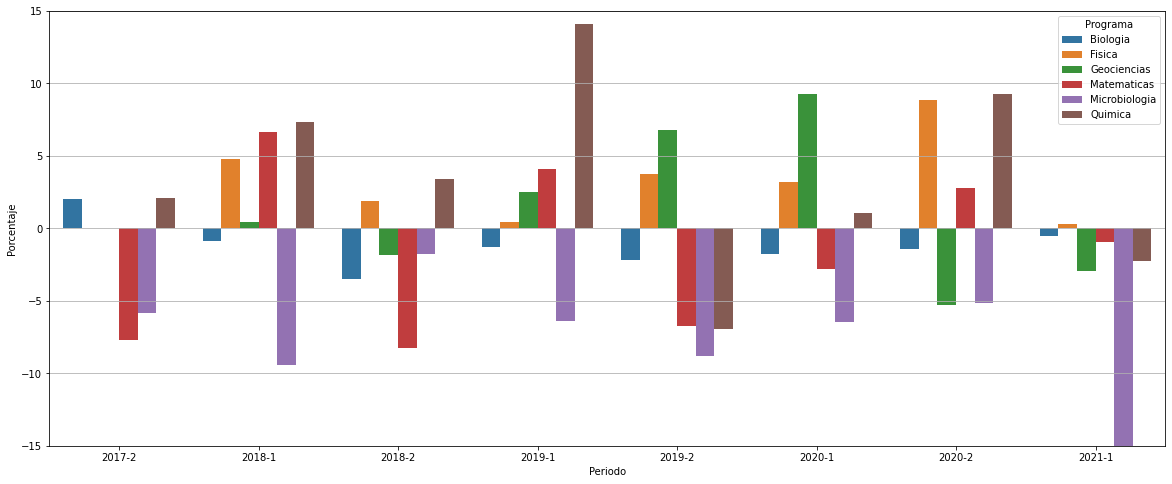

In [370]:
plt.figure(figsize=(20,8))
plt.grid()
plt.ylim(-15,15)
sns.barplot(data=p_desertoresPlot, x='Periodo', y='Porcentaje', hue='Programa')

## Definición de nuestro modelo

Definimos ahora nuestro target (esta tasa de Desercion-Reingreso normalizada), siendo -1 para los casos en los que hay más reingresos que deserciones, y +1 para los que ocurre lo contrario.

In [428]:
target = p_desertores[years[2:7]]
target = target/np.abs(target)
target

,2018-1,2018-2,2019-1,2019-2,2020-1
0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,-1.0,1.0,1.0,1.0
3,1.0,-1.0,1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0
5,1.0,1.0,1.0,-1.0,1.0


Creamos ahora nuestro set de datos predictores, específicamente, para predecir si la tasa en un periodo es positiva o negativa, utilizaremos el número de estudiantes, el número de graduados, el de matriculados, y los cursos inscritos por los estudiantes del pregrado en el periodo inmediátamente anterior. El motivo por el que escogimos los años hasta el 2020-1, es porque la pandemia y sus consecuencias, al ser un evento impredecible, será muy problemático de predecir utilizando un entrenamiento de los años anteriores.

In [442]:
years_predictors = ['2017-2', '2018-1', '2018-2', '2019-1', '2019-2', '2020-1']

year = years_predictors[0]
next_year = years_predictors[1]
predictors = pd.DataFrame([p_total[year], p_matriculados[year], p_graduados[year], p_cursos[year], target[next_year]]).T
predictors.columns = ['x1', 'x2', 'x3', 'x4', 'y']
data = predictors

for i in range(1, len(years_predictors)-1):
  year = years_predictors[i]
  next_year = years_predictors[i+1]
  predictors = pd.DataFrame([p_total[year], p_matriculados[year], p_graduados[year], p_cursos[year], target[next_year]]).T
  predictors.columns = ['x1', 'x2', 'x3', 'x4', 'y']
  data = pd.concat([data, predictors], axis=0)

predictors= np.array(['Estudiantes totales', 'Matriculados', 'Graduados', 'Cursos inscritos'])

Dividimos ahora los datos entre predictores y targets, y visualizamos si ambas clases objetivos están balanceadas.

Text(0, 0.5, 'Cantidad')

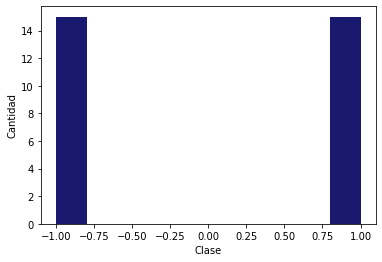

In [443]:
X = data[['x1', 'x2', 'x3', 'x4']]
Y = data['y']
plt.hist(Y, color='midnightblue')
plt.xlabel('Clase')
plt.ylabel('Cantidad')

Escogemos un 20% de los datos aleátoriamente como test, y el otro 80% como entrenamiento.

In [377]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)
print(np.shape(X_train), np.shape(Y_train))

(24, 4) (24,)


Llamamos ahora un AdaBoost Clasificador para clasificar los datos, el número de estimadores y el ratio de aprendizaje es, inicialmente, arbitrario

In [378]:
AdaB = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=10, learning_rate=0.1)
AdaB.fit(X_train, Y_train)
print(f1_score(Y_test, AdaB.predict(X_test)))

0.8


Visualizamos ahora nuestro árbol de desición

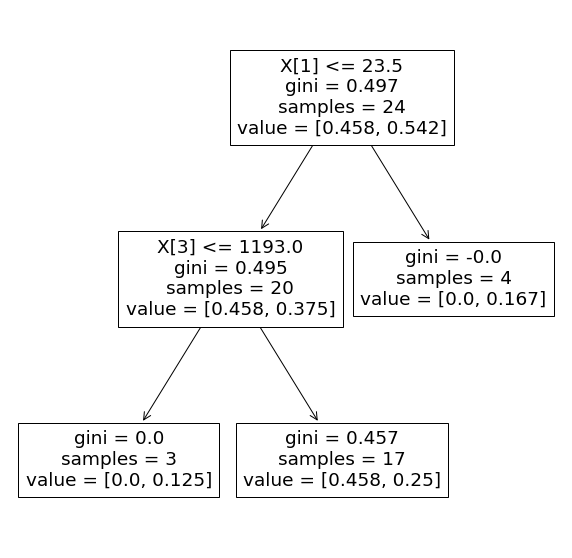

In [379]:
plt.figure(figsize=(10,10))
_= plot_tree(AdaB.estimators_[0])

Y realizamos un search grid para hallar los metaparámetros que nos ofrecen mejores resultados en la clasificación.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier ins

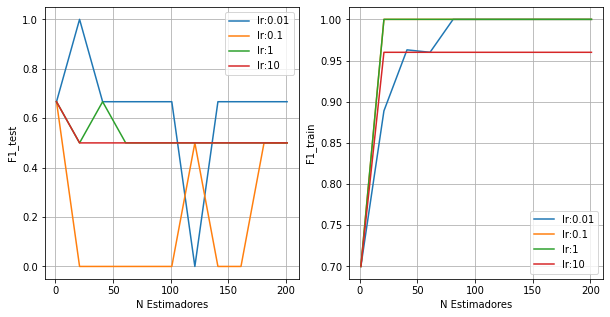

In [407]:
learning_rates = [0.01,0.1,1,10]
n_estimators = np.arange(1,220,20)

fig = plt.figure(figsize=(10,5))

for lr in learning_rates:
    f1_test = []
    f1_train = []

    for ne in n_estimators:
        AdaB = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=ne, learning_rate=lr)
        AdaB.fit(X_train, Y_train)
        f1_test.append( f1_score(Y_test, AdaB.predict(X_test)) )
        f1_train.append( f1_score(Y_train, AdaB.predict(X_train)) )
        
    plt.subplot(1,2,1)
    plt.plot(n_estimators,f1_test, label=f'lr:{lr}')
    
    plt.subplot(1,2,2)
    plt.plot(n_estimators,f1_train, label=f'lr:{lr}')

    
plt.subplot(1,2,1)
plt.grid()
plt.legend()
plt.xlabel('N Estimadores')
plt.ylabel('F1_test')

plt.subplot(1,2,2)
plt.grid()
plt.legend()
plt.xlabel('N Estimadores')
plt.ylabel('F1_train')

plt.show()

Ya con los resultados de los mejores metaparámetros obtenidos, podemos crear nuevamente nuestro modelo para que prediga de mejor manera los datos.

In [417]:
AdaB = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=20, learning_rate=0.01)
AdaB.fit(X_train, Y_train)
f1_score(Y_test,AdaB.predict(X_test))

1.0

## Resultados y conclusiones

Para concluir, graficamos la importancia de cada uno de nuestros 4 predictores, para visualizar cuales de ellos son los que de mejor manera influyen en nuestra predicción de la tasa.

Text(0.5, 0, 'Importancia')

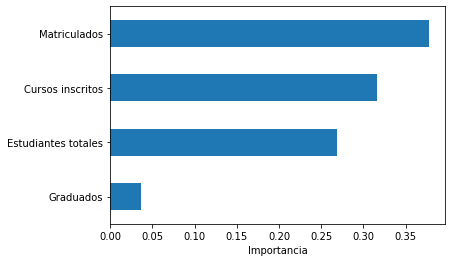

In [444]:
ii = np.argsort(AdaB.feature_importances_)

importances = AdaB.feature_importances_[ii]
predictorsPlot = predictors[ii]

a = pd.Series(importances, index=predictorsPlot)
a.plot(kind='barh')
plt.xlabel('Importancia')

Finalmente, graficamos nuestra matrix de confusión para verificar que las predicciones son completamente concordantes con nuestro F1_Score hallado.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


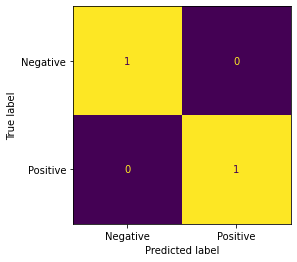

In [446]:
plot_confusion_matrix(AdaB, X_test, Y_test, normalize='true', display_labels=['Negative', 'Positive'], colorbar=False)